In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('Dataframe_Boligsiden_Distance.csv', sep=';')

# Data Cleaning

In [2]:
df = pd.read_csv('cleaned_data.csv', sep=';')

In [3]:
# Create dummy variables for the 'Category' column
dummy_1 = pd.get_dummies(df['property_type'], prefix='type')
dummy_2 = pd.get_dummies(df['heating_source'], prefix = '')

# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_1,dummy_2], axis=1)

In [4]:
df_with_dummies

,Rum,Toilet,Boligareal,Grundareal,Kontantpris,Ejerudgift,Plan,latitude,longitude,city_distance,...,close_city_Copenhagen,close_city_Odense,type_Andelsbolig,type_Lejlighed,type_Rækkehus,type_Villa,_clean_renewable,_non_clean,_non_renewable,_other
0,6,2,190,1,4945000,3,1,55.76619,9.54160,60.51143,...,0,0,0,0,0,1,1,0,0,0
1,5,3,187,1,3995000,3,1,55.68278,9.56109,61.33861,...,0,1,0,0,0,1,1,0,0,0
2,4,2,146,930,3495000,2,2,55.69920,9.54617,63.09367,...,0,1,0,0,0,1,0,0,1,0
3,5,2,143,391,7395000,3,1,55.71265,9.53506,64.48529,...,0,1,0,0,0,1,1,0,0,0
4,4,2,150,617,2195000,2,2,55.70025,9.54549,63.19188,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,4,1,96,734,2875000,1,1,55.72645,12.35758,14.38579,...,1,0,0,1,0,0,1,0,0,0
4778,3,1,70,583,1395000,2,1,55.39549,10.42292,2.03041,...,0,1,0,1,0,0,1,0,0,0
4779,5,2,80,525,1499000,1,1,55.38837,10.41380,1.69283,...,0,1,0,1,0,0,1,0,0,0
4780,2,2,63,318,1175000,2,2,56.47082,10.02701,35.99106,...,0,0,0,1,0,0,1,0,0,0


In [5]:
df_clean = df_with_dummies.drop(columns=['Energimærke_nan', 'property_type',
                                         'heating_source'])
df_clean = df_clean.dropna().reset_index(drop=True)

In [6]:
df_clean['Ejerudgift'] = df_clean['Ejerudgift'].astype(str)
df_clean['Ejerudgift'] = df_clean['Ejerudgift'].str.replace(".", "")
df_clean['Ejerudgift'] = df_clean['Ejerudgift'].astype(float)
df_clean

C:\Users\marko\AppData\Local\Temp/ipykernel_16576/557726641.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_clean['Ejerudgift'] = df_clean['Ejerudgift'].str.replace(".", "")


,Rum,Toilet,Boligareal,Grundareal,Kontantpris,Ejerudgift,Plan,latitude,longitude,city_distance,...,close_city_Copenhagen,close_city_Odense,type_Andelsbolig,type_Lejlighed,type_Rækkehus,type_Villa,_clean_renewable,_non_clean,_non_renewable,_other
0,6,2,190,1,4945000,3.0,1,55.76619,9.54160,60.51143,...,0,0,0,0,0,1,1,0,0,0
1,5,3,187,1,3995000,3.0,1,55.68278,9.56109,61.33861,...,0,1,0,0,0,1,1,0,0,0
2,4,2,146,930,3495000,2.0,2,55.69920,9.54617,63.09367,...,0,1,0,0,0,1,0,0,1,0
3,5,2,143,391,7395000,3.0,1,55.71265,9.53506,64.48529,...,0,1,0,0,0,1,1,0,0,0
4,4,2,150,617,2195000,2.0,2,55.70025,9.54549,63.19188,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4777,4,1,96,734,2875000,1.0,1,55.72645,12.35758,14.38579,...,1,0,0,1,0,0,1,0,0,0
4778,3,1,70,583,1395000,2.0,1,55.39549,10.42292,2.03041,...,0,1,0,1,0,0,1,0,0,0
4779,5,2,80,525,1499000,1.0,1,55.38837,10.41380,1.69283,...,0,1,0,1,0,0,1,0,0,0
4780,2,2,63,318,1175000,2.0,2,56.47082,10.02701,35.99106,...,0,0,0,1,0,0,1,0,0,0


Remove outliers

In [7]:
columns_to_remove_outliers = ['Kontantpris','Ejerudgift','Boligareal','city_distance', 'Rum', 'Age', 'Grundareal']

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for column in columns_to_remove_outliers:
    df_clean = remove_outliers_iqr(df_clean, column)

Drop duplicates

In [8]:
duplicates = df_clean[df_clean.duplicated()]
print(duplicates.shape)
df_clean = df_clean.drop_duplicates()

(24, 39)


Focus just on Copenhagen. <br>
Or decrease the distance to cities.

In [9]:
#df_clean = df_clean[df_clean['close_city_Copenhagen'] == 1]
#df_clean = df_clean.drop(columns=['close_city_Aarhus','close_city_Copenhagen','close_city_Odense'])
#df_clean = df_clean[df_clean['city_distance'] <= 20]
#df_clean

# Machine learning models

In [57]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.linear_model import LassoCV

In [58]:
y = df_clean['Kontantpris']
X = df_clean.drop(columns=['Kontantpris'])

In [72]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.1, random_state=10)
#X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=10)

## Linear Regression

In [78]:
pipe_lr = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_dev, y_dev)
y_train_pred = pipe_lr.predict(X_dev)
y_test_pred = pipe_lr.predict(X_test)

train_rmse = np.sqrt(mse(y_dev, y_train_pred))
test_rmse = np.sqrt(mse(y_test, y_test_pred))
print(train_rmse,test_rmse)

818841.428221315 825322.9755089483


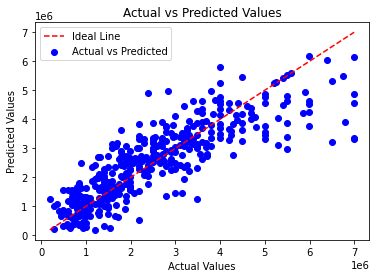

In [79]:
# Plot y_test vs y_pred
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [80]:
r2_linear = r2_score(y_test, y_test_pred)
r2_linear

0.7041820859985026

In [81]:
coefficients = pipe_lr.get_params(deep=True)
print("Coefficients:", coefficients)


Coefficients: {'memory': None, 'steps': [('polynomialfeatures', PolynomialFeatures(degree=1, include_bias=False)), ('standardscaler', StandardScaler()), ('linearregression', LinearRegression())], 'verbose': False, 'polynomialfeatures': PolynomialFeatures(degree=1, include_bias=False), 'standardscaler': StandardScaler(), 'linearregression': LinearRegression(), 'polynomialfeatures__degree': 1, 'polynomialfeatures__include_bias': False, 'polynomialfeatures__interaction_only': False, 'polynomialfeatures__order': 'C', 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'linearregression__copy_X': True, 'linearregression__fit_intercept': True, 'linearregression__n_jobs': None, 'linearregression__normalize': False, 'linearregression__positive': False}


In [82]:
coefficients = pipe_lr.named_steps['linearregression'].coef_
print("Coefficients:", coefficients)
scaling_factors = pipe_lr.named_steps['standardscaler'].scale_
rescaled_coefficients = coefficients / scaling_factors

Coefficients: [ 1.44860538e+04  7.34989611e+04  2.19761804e+05  3.06661657e+04
  8.74054497e+05 -1.78625250e+04  2.13904407e+04 -1.83335674e+05
 -4.15039313e+05 -1.07768245e+04  1.52168411e+05 -5.59038198e+03
 -1.23969019e+05 -2.45862103e+05 -1.91561865e+05 -1.36967452e+05
 -1.28189238e+05  1.72481339e+15  1.72481339e+15  1.13402579e+15
 -3.15493461e+16 -3.15493461e+16 -7.42919475e+16 -7.42919475e+16
 -7.03583982e+16 -7.03583982e+16 -3.74905339e+16 -6.26918385e+16
 -6.57126686e+16 -5.72302761e+16 -5.69541740e+15 -1.64566541e+16
 -1.28458226e+16 -1.95374565e+16  2.27993649e+17  1.31389938e+17
  1.89210875e+17  5.81317859e+16]


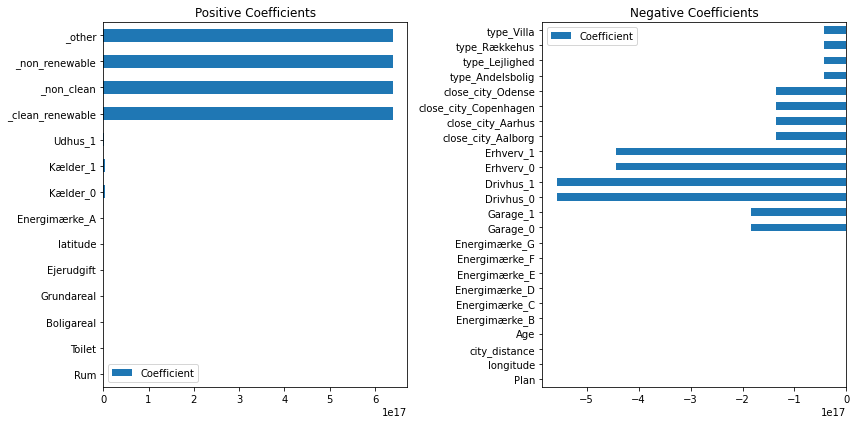

In [83]:
# Create a DataFrame with rescaled coefficients and feature names
coef_df = pd.DataFrame(rescaled_coefficients, X.columns, columns=['Coefficient'])

# Split coefficients into positive and negative parts
positive_coef = coef_df[coef_df['Coefficient'] > 0]
negative_coef = coef_df[coef_df['Coefficient'] < 0]

# Create subplots with positive and negative coefficients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
positive_coef.plot(kind='barh', ax=ax1)
negative_coef.plot(kind='barh', ax=ax2)

ax1.set_title('Positive Coefficients')
ax2.set_title('Negative Coefficients')

plt.tight_layout()
plt.show()

## Lasso

In [86]:
perform = [] # Store performance
lambdas = np.logspace(-8, 8, 10) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=1, include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=161193))
    pipe_lasso.fit(X_dev, y_dev)
    y_pred = pipe_lasso.predict(X_test)
    perform.append(mse(y_pred, y_test))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Test MSE: %.3f' % optimal.values[0])

C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101781009825421.75, tolerance: 838137451258.7186
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101585475129407.5, tolerance: 838137451258.7186
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101586759838934.0, tolerance: 838137451258.7186
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarni

Optimal lambda: 464.1588833612773
Test MSE: 680615228389.558


C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79792540938090.5, tolerance: 838137451258.7186
  model = cd_fast.enet_coordinate_descent(


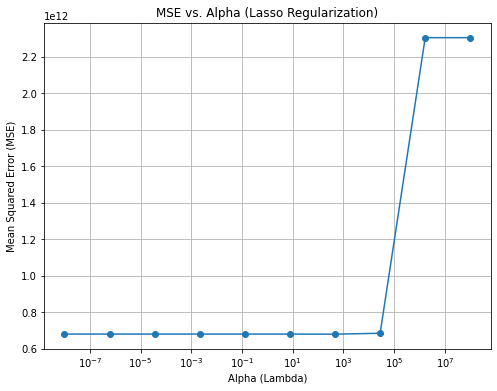

In [87]:
# Create a line plot of MSE values
plt.figure(figsize=(8, 6))
plt.plot(lambdas, perform, marker='o')
plt.xscale('log')  # Use a logarithmic scale for x-axis (optional)
plt.title('MSE vs. Alpha (Lasso Regularization)')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_squared_error as mse

scaler = StandardScaler()

X_dev = scaler.fit_transform(X_dev)
X_test = scaler.transform(X_test)

lasso_model = Lasso(alpha=6158.482110660255)  # Adjust the alpha parameter as needed
lasso_model.fit(X_dev, y_dev)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rmse = np.sqrt(mse(y_test, y_pred))
print("RMSE:",rmse)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

RMSE: 837391.4680914455
R-squared: 0.6963025944138226


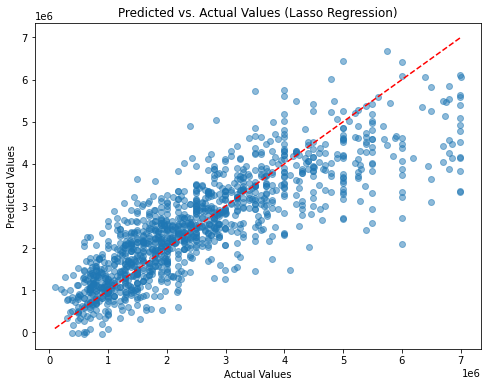

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Predicted vs. Actual Values (Lasso Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [23]:
alphas = np.logspace(-8, 8, 100)
# Create LassoCV model with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=161193)

# Fit the model to your data
lasso_cv.fit(X_dev, y_dev)

# Get the best alpha value
best_alpha = lasso_cv.alpha_
print("Best Alpha:", best_alpha)

# Calculate R-squared on the test set
r2 = lasso_cv.score(X_test, y_test)
print("R-squared:", r2)

Best Alpha: 1417.4741629268076
R-squared: 0.6966825836963368


## Ridge

In [77]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse



performance = [] # Store performance
lambdas = np.logspace(-8, 8, 20) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=1, include_bias=False), 
                           StandardScaler(),
                           Ridge(alpha=6400, random_state=161193))
    pipe_ridge.fit(X_dev,y_dev)
    y_pred = pipe_ridge.predict(X_test)
    performance.append(mse(y_pred, y_test))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(performance,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 1e-08
Validation MSE: 1198881462166.713


In [126]:
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1, include_bias=False), 
                           StandardScaler(),
                           Ridge(alpha=6400, random_state=161193))
pipe_ridge.fit(X_dev,y_dev)
y_pred = pipe_ridge.predict(X_test)
# Calculate Mean Squared Error
print(np.sqrt(mse(y_test, y_pred)))

1104374.922628878


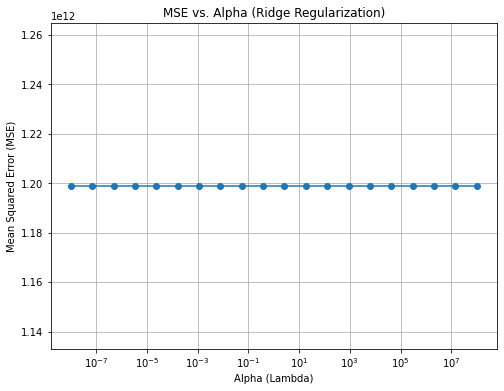

In [79]:
# Create a line plot of MSE values
plt.figure(figsize=(8, 6))
plt.plot(lambdas, performance, marker='o')
plt.xscale('log')  # Use a logarithmic scale for x-axis (optional)
plt.title('MSE vs. Alpha (Ridge Regularization)')
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()

In [65]:
from sklearn.linear_model import RidgeCV

# Create a range of alpha values on a logarithmic scale
alphas = np.logspace(-8, 8, 100)

# Create RidgeCV model with cross-validation
ridge_cv = RidgeCV(alphas=alphas, cv=5)

# Fit the model to your data
ridge_cv.fit(X_dev, y_dev)

# Get the best alpha value
best_alpha = ridge_cv.alpha_
print("Best Alpha:", best_alpha)

# Calculate R-squared on the test set
r2 = ridge_cv.score(X_test, y_test)
print("R-squared:", r2)

Best Alpha: 34.30469286314926
R-squared: 0.7039017182276783


## Model Validation

Select optimal hypterparameters

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

lambdas = np.logspace(-4, 4, 10) # Grid of lambdas

pipe_el = make_pipeline(PolynomialFeatures(degree=1, include_bias=False), 
                        StandardScaler(),
                        ElasticNet())

gs = GridSearchCV(estimator=pipe_el, 
                  param_grid={'elasticnet__alpha':lambdas,
                              'elasticnet__l1_ratio':np.linspace(0,1,10)}, 
                  scoring='neg_mean_squared_error', 
                  cv=5)

#gs.fit(X_dev, y_dev)
#print(mse(gs.predict(X_test),y_test))

In [73]:
# Create a parameter grid for alpha and l1_ratio
param_grid = {
    'alpha': np.logspace(-6, 2, 9),      # Range of alpha values on a logarithmic scale
    'l1_ratio': np.linspace(0.0, 1.0, 11) # Range of l1_ratio values from 0 to 1
}

# Create ElasticNet model
elastic_net = ElasticNet()

# Create GridSearchCV instance
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
"""
# Fit the grid search to your data
grid_search.fit(X_dev, y_dev)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Calculate R-squared on the test set
r2 = r2_score(y_test, y_pred)
print("Best Parameters:", best_params)
print("Best R-squared:", r2)"""

'\n# Fit the grid search to your data\ngrid_search.fit(X_dev, y_dev)\n\n# Get the best parameters and model\nbest_params = grid_search.best_params_\nbest_model = grid_search.best_estimator_\n\n# Make predictions using the best model\ny_pred = best_model.predict(X_test)\n\n# Calculate R-squared on the test set\nr2 = r2_score(y_test, y_pred)\nprint("Best Parameters:", best_params)\nprint("Best R-squared:", r2)'

## Compare Models

### Learning curves

In [25]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(10)

,Train,Test
sample size,,
126,3.755215e+11,8.426569e+11
252,4.722672e+11,7.429620e+11
378,5.698278e+11,7.265892e+11
504,6.131262e+11,7.112698e+11
630,6.061903e+11,7.047100e+11
756,6.300867e+11,6.967264e+11
882,6.291141e+11,6.911030e+11
1008,6.367953e+11,6.895193e+11
1134,6.526963e+11,6.881332e+11


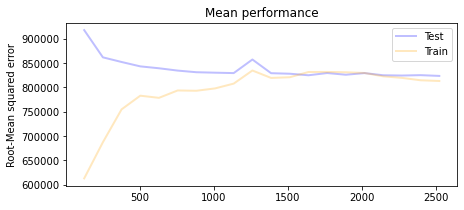

In [26]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend();

# Normal OLS for comparison

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Add a constant term to X
X = sm.add_constant(X)

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Kontantpris   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     326.3
Date:                Thu, 17 Aug 2023   Prob (F-statistic):               0.00
Time:                        13:39:26   Log-Likelihood:                -60170.
No. Observations:                4002   AIC:                         1.204e+05
Df Residuals:                    3971   BIC:                         1.206e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Rum                    1.103e+

C:\Users\marko\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [43]:
X

,Rum,Toilet,Boligareal,Grundareal,Ejerudgift,Plan,latitude,longitude,city_distance,Age,...,close_city_Copenhagen,close_city_Odense,type_Andelsbolig,type_Lejlighed,type_Rækkehus,type_Villa,_clean_renewable,_non_clean,_non_renewable,_other
0,6,2,190,1,3.0,1,55.76619,9.54160,60.51143,4.0,...,0,0,0,0,0,1,1,0,0,0
1,5,3,187,1,3.0,1,55.68278,9.56109,61.33861,66.0,...,0,1,0,0,0,1,1,0,0,0
2,4,2,146,930,2.0,2,55.69920,9.54617,63.09367,47.0,...,0,1,0,0,0,1,0,0,1,0
4,4,2,150,617,2.0,2,55.70025,9.54549,63.19188,96.0,...,0,1,0,0,0,1,1,0,0,0
5,6,2,205,978,3.0,1,55.66663,9.58133,59.32748,3.0,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4775,5,2,126,1,3.0,2,55.24669,9.50328,58.75399,102.0,...,0,1,0,1,0,0,1,0,0,0
4776,4,1,123,888,2.0,1,55.25496,9.49554,58.96754,84.0,...,0,1,0,1,0,0,1,0,0,0
4778,3,1,70,583,2.0,1,55.39549,10.42292,2.03041,107.0,...,0,1,0,1,0,0,1,0,0,0
4779,5,2,80,525,1.0,1,55.38837,10.41380,1.69283,76.0,...,0,1,0,1,0,0,1,0,0,0


In [56]:
from sklearn.compose import ColumnTransformer

# Columns for which you want to create polynomial features
columns_to_transform = [0, 36]  # Change this to the indices of the columns you want
"""
preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False), columns_to_transform),
        ('passthrough', 'passthrough', [0]),  # Include column 0 unchanged
    ]
)
"""
pipe_lr = make_pipeline(PolynomialFeatures(degree=2, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

# Transform the selected columns with polynomial features and standardization
#X_poly_std = pipeline.fit_transform(X_dev[:, columns_to_transform])

pipe_lr.fit(X_dev, y_dev)
y_train_pred = pipe_lr.predict(X_dev)
y_test_pred = pipe_lr.predict(X_test)

train_rmse = np.sqrt(mse(y_dev, y_train_pred))
test_rmse = np.sqrt(mse(y_test, y_test_pred))
print(train_rmse,test_rmse)

630436.2129885447 7.150497440932247e+19


# Data Visualization

In [33]:
apply_fcts = ['median', 'mean']
mean_prices = df.groupby('property_type')['Kontantpris'].agg(apply_fcts)

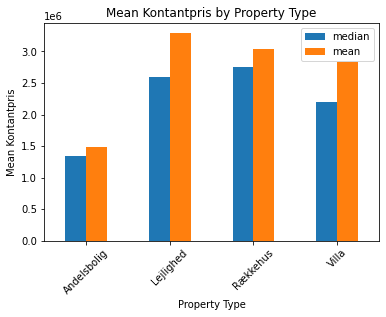

In [34]:
mean_prices.plot(kind='bar')
plt.xlabel('Property Type')
plt.ylabel('Mean Kontantpris')
plt.title('Mean Kontantpris by Property Type')
plt.xticks(rotation=45)
plt.show()

In [35]:
# Specify the columns and statistics you want
selected_columns = ['Kontantpris', 'Rum', 'Toilet', 'Boligareal', 'Grundareal', 'Age', 'close_city_Copenhagen', 'close_city_Odense', 'close_city_Aarhus']
selected_stats = ['count', 'mean', 'min', 'max']

# Calculate descriptive statistics
statistics = df[selected_columns].agg(selected_stats)
formatted_statistics = statistics.applymap(lambda x: int(x) if x == int(x) else int(round(x)))
formatted_statistics

,Kontantpris,Rum,Toilet,Boligareal,Grundareal,Age,close_city_Copenhagen,close_city_Odense,close_city_Aarhus
count,4782,4782,4782,4782,4782,4782,4782,4782,4782
mean,2909893,5,2,143,2102,71,0,0,0
min,95000,1,1,21,0,-1,0,0,0
max,32500000,19,7,735,339000,446,1,1,1


In [125]:
# Convert statistics to LaTeX table
latex_table = formatted_statistics.to_latex()

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  Kontantpris &   Rum &  Toilet &  Boligareal &  Grundareal &   Age &  close\_city\_Copenhagen &  close\_city\_Odense &  close\_city\_Aarhus \\
\midrule
count &         4782 &  4782 &    4782 &        4782 &        4782 &  4782 &                   4782 &               4782 &               4782 \\
mean  &      2909893 &     5 &       2 &         143 &        2102 &    71 &                      0 &                  0 &                  0 \\
min   &        95000 &     1 &       1 &          21 &           0 &    -1 &                      0 &                  0 &                  0 \\
max   &     32500000 &    19 &       7 &         735 &      339000 &   446 &                      1 &                  1 &                  1 \\
\bottomrule
\end{tabular}

